### First let's set up the project

We'll be using pandas and numpy for data handling, beautifulsoup for html data extraction, spacy for text cleaning and word embeddings and sklearn for model training and evaluation.

Python version used for the project is 3.9.4. Using versions prior to 3.9 will raise some exceptions, as past versions of Python do not support complex type annotations with inbuilt types, typing modules would need to be used to replace those.

In [1]:
# !pip install -r requirements.txt
# !python -m spacy download de_core_news_sm

In [2]:
from warnings import filterwarnings

filterwarnings("ignore")

In [3]:
import os
import re
from copy import copy
from pprint import pprint

from bs4 import BeautifulSoup

import pandas as pd
import numpy as np

import spacy

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.base import BaseEstimator
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.corpora import Dictionary
from gensim.models import LdaMulticore

import matplotlib.pyplot as plt

### Next we'll extract texts from provided HTML files 

We'll decompose `style` and `script` tags as they are not our actual textual data and then extract all other texts from files for further processing.

In [4]:
def extract_html_text(filepath: str) -> str:
    """
    Extracts test data from HTML file on provided path.
    """
    # Open the file and load it to BeautifulSoup
    with open(filepath, encoding='ISO-8859-1') as f:
        soup = BeautifulSoup(f.read(), "html")
    
    # Decompose script and style tags
    tags_to_decompose = [
        tag 
        for tag_name in ("style", "script")
        for tag in soup.find_all(tag_name)
    ]
    for tag in tags_to_decompose:
        tag.decompose()
    
    # Return only texts from the file
    return soup.get_text(" ")

# Test the function on a single file
extract_html_text(os.path.join("htmls", "0.html"))

'\n \n \n \n \n \n \n BauchspeicheldrÃ¼se | Klinik fÃ¼r Allgemein-, Viszeral- und Kinderchirurgie GÃ¶ttingen \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n Klinik fÃ¼r Allgemein-, Viszeral- und Kinderchirurgie \n zur Hauptnavigation springen \n zum Inhalt wechseln \n \n Aktuelles und Kontakt Kontakt \n \n \n Logo der UniverstÃ¤tsmedizin GÃ¶ttingen \n \n \n \n \n \n \n \n \n \n Navigation Ã¶ffnen oder schliessen \n \n \n \n \n \n \n Hauptnavigation Subnavigation Ã¶ffnen oder schliessen Medizinische Versorgung Poliklinik Sonographie SchilddrÃ¼se SpeiserÃ¶hre und Magen Darm BauchspeicheldrÃ¼se CED Leber und Galle Hernien Koloproktologie Adipositaschirurgie Kinderchirurgie Sarkomchirurgie HIPEC Roboterchirurgie InterdisziplinÃ¤re Zentren Subnavigation Ã¶ffnen oder schliessen Forschung Klinische Studien Tumorepigenetik AG Conradi AG Gaedcke AG Grade AG Krause AG Sperling AG Sprenger AG Wegwitz Promotion Publikationen Subnavigation Ã¶ffnen oder schliessen Lehre Module Blockpraktikum Famulature

Let's define a function that will extract data from all files and return it as a dictionary with document ids as keys and texts as values.

In [5]:
def extract_all_texts(directory) -> dict[int, str]:
    """
    Extracts texts from all HTML files in provided directory
    """
    return {
        int(file.replace(".html", "")): extract_html_text(os.path.join(directory, file))
        for file in os.listdir("htmls")
    }

all_texts = extract_all_texts("htmls")

### Now let's load our training data

We'll load the data to pandas DataFrame to make further processing easier

In [6]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df

,url,doc_id,label
0,http://elbe-elster-klinikum.de/fachbereiche/ch...,1,1
1,http://klinikum-bayreuth.de/einrichtungen/zent...,3,3
2,http://klinikum-braunschweig.de/info.php/?id_o...,4,1
3,http://klinikum-braunschweig.de/info.php/?id_o...,5,1
4,http://klinikum-braunschweig.de/zuweiser/tumor...,6,3
...,...,...,...
95,http://www.unicross.uni-freiburg.de/thema/unifm/,140,1
96,http://www.uniklinik-duesseldorf.de/patienten-...,141,1
97,http://www.vivantes.de/fuer-sie-vor-ort/klinik...,144,2
98,http://www.vivantes.de/fuer-sie-vor-ort/klinik...,145,2


Let's remove `url` column as it's not needed and load texts to another column

In [7]:
for df_ in (train_df, test_df):
    del df_['url']
    df_['text'] = df_['doc_id'].apply(lambda x: all_texts[x])
train_df

,doc_id,label,text
0,1,1,\n \n \n \n \n \n \n \n Elbe-Elster Klinikum -...
1,3,3,\n \n \n \n \n \n \n \n Onkologisches Zentrum ...
2,4,1,\n \n \n Zentrum - SozialpÃ¤diatrisches Zentru...
3,5,1,\n \n \n Leistung - Spezielle UnterstÃ¼tzung b...
4,6,3,\n \n \n Zuweiser - Tumorkonferenzen - Tumorko...
...,...,...,...
95,140,1,\n \n \n \n \n \n \n \n \n \n \n \n uniFM | un...
96,141,1,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \...
97,144,2,\n \n \n \n \n \n \n \n \n \n \n \n \n FÃ¼r Ã...
98,145,2,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n I...


Let's also check how much data we have for each label

In [8]:
train_df.label.value_counts()

2    59
1    32
3     9
Name: label, dtype: int64

As we can see there's a huge imbalance in our data distribution. Groups proportions are roughly 7:4:1. 

We'll try to tackle this issue with a couple of approaches:
- oversamling of the least populated group
- using topic modelling
- grouping labels 2 and 3 together to perform binary classification

But first let's clean our data.

### Now we'll be cleaning and tokenizing our data

For that purpose we'll use spacy and it's pre-trained German language model. We'll be using the smallest one available, larger ones could provide better performence, however they're quite big and slow.

In [9]:
nlp = spacy.load("de_core_news_sm")

Let's define our tokenizing and cleaning functions

In [10]:
PATTERNS = [
    (re.compile('\s+'), ""),
    (re.compile('<[^>]*>'), ""),
    (re.compile('[\W]+'), ""),
    (re.compile('\d+'), "#num"),
]

def preprocessor(token: str) -> str:
    """
    Removes punctuation from text using regular expressions
    and replaces all numbers with a #num token
    """
    global PATTERNS
    
    text = token.lower()
    for ptrn, sub in PATTERNS:
        text = ptrn.sub(sub, text)
    
    return text

def check_token(token: spacy.tokens.Token) -> bool:
    """
    Checks token against a few conditions:
    - checks if token is a stopword
    - checks if token's length is longer than 2 characters
    """
    return all([
        not token.is_stop,
        len(token.lemma_) >= 3
    ])

def tokenize(text: str) -> list[str]:
    """
    Extracts a list of word lemmas from spacy's sentence object.
    Stopwords are filtered out as well as tokens representing only
    whitespace or punctuation.
    """
    global nlp
    
    # Convert text to spacy Doc object
    doc = nlp(text)
    
    # Tokenize text, lemmatize and preprocess tokens and 
    # filter out stopwords
    lemmas = [
        preprocessor(token.lemma_)
        for token in doc
        if check_token(token)
    ]
    # Return only non-empty tokens
    return [lem for lem in lemmas if lem]

And now apply them to our texts

In [11]:
for df_ in (train_df, test_df):
    df_['tokens'] = df_['text'].apply(tokenize)
    df_['clean_text'] = df_['tokens'].apply(lambda toks: " ".join(toks))
    
train_df

,doc_id,label,text,tokens,clean_text
0,1,1,\n \n \n \n \n \n \n \n Elbe-Elster Klinikum -...,"[elbeelster, klinikum, chirurgie, finsterwalde...",elbeelster klinikum chirurgie finsterwalde suc...
1,3,3,\n \n \n \n \n \n \n \n Onkologisches Zentrum ...,"[onkologisches, zentrum, klinikum, bayreuth, a...",onkologisches zentrum klinikum bayreuth aktuel...
2,4,1,\n \n \n Zentrum - SozialpÃ¤diatrisches Zentru...,"[zentrum, sozialpãdiatrisches, zentrum, stãdti...",zentrum sozialpãdiatrisches zentrum stãdtische...
3,5,1,\n \n \n Leistung - Spezielle UnterstÃ¼tzung b...,"[leistung, speziell, unterstã¼tzung, anmeldung...",leistung speziell unterstã¼tzung anmeldung geb...
4,6,3,\n \n \n Zuweiser - Tumorkonferenzen - Tumorko...,"[zuweiser, tumorkonferenzen, tumorkonferenz, g...",zuweiser tumorkonferenzen tumorkonferenz gastr...
...,...,...,...,...,...
95,140,1,\n \n \n \n \n \n \n \n \n \n \n \n uniFM | un...,"[unifm, unicross, news, and, magazin, theme, h...",unifm unicross news and magazin theme home kon...
96,141,1,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \...,"[interdisziplinãre, neurovaskulãre, konferenz,...",interdisziplinãre neurovaskulãre konferenz ukd...
97,144,2,\n \n \n \n \n \n \n \n \n \n \n \n \n FÃ¼r Ã...,"[fã¼r, ãrzte, vivantes, javascript, scheinen, ...",fã¼r ãrzte vivantes javascript scheinen browse...
98,145,2,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n I...,"[innere, medizin, â, hãmatologie, onkologie, p...",innere medizin â hãmatologie onkologie palliat...


Now we'll oversample our data so that there are 20 samples for label 3

In [12]:
class_3_oversample = train_df[train_df.label == 3].sample(20, replace=True, random_state=0)
os_train_df = pd.concat([train_df[train_df.label != 3], class_3_oversample])
os_train_df.label.value_counts()

2    59
1    32
3    20
Name: label, dtype: int64

### Model training

This is time to finally try out our data on an actual model. We'll start with a simple LogisticRegression. But first we'll define model evaluating functions.

In [13]:
def eval_model(
    clf: BaseEstimator, 
    x_test: np.ndarray, 
    y_test: np.ndarray
) -> None:
    """
    Calculates and displays evaluation metrics 
    for passed classifier and data
    """
    y_pred = clf.predict(x_test)
    
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    plot_confusion_matrix(clf, x_test, y_test)
    plt.show()
    
    print(f'Accuracy {acc}\n')
    print(report)
    
    
def fit_and_eval(
    clf: BaseEstimator, 
    X_trn: np.ndarray, 
    x_test: np.ndarray, 
    Y_trn: np.ndarray, 
    y_test: np.ndarray
) -> BaseEstimator:
    """
    Trains and evaluates passed classifier
    with passed data
    """
    clf.fit(X_trn, Y_trn)
    
    eval_model(clf, x_test, y_test)
    
    return clf

### Spacy vectors

Now we'll transform text data into vectors. First we'll try to use spacy's pre-defined word embeddings from the language model we're using. Then we'll split the data for training and evalutation.

In [14]:
x = np.stack(os_train_df['clean_text'].apply(lambda txt: nlp(txt).vector))
y = os_train_df.label.to_numpy()

X_train, x_val, Y_train, y_val = train_test_split(x, y, train_size=0.9, shuffle=True, random_state=1, stratify=y)

And train the model.

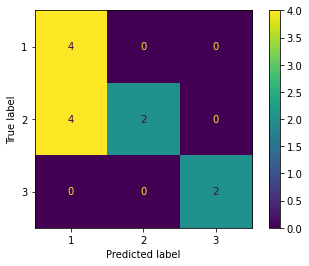

Accuracy 0.6666666666666666

              precision    recall  f1-score   support

           1       0.50      1.00      0.67         4
           2       1.00      0.33      0.50         6
           3       1.00      1.00      1.00         2

    accuracy                           0.67        12
   macro avg       0.83      0.78      0.72        12
weighted avg       0.83      0.67      0.64        12



In [15]:
lgr = fit_and_eval(
    LogisticRegression(n_jobs=10, C=1, class_weight="balanced"),
    X_train, x_val, Y_train, y_val
)

Results aren't outstanding. Classifier mostly mistakes pages of class 2 for class 1, which is understandable as they're pages with lower level of certainty regarding being about tumorboards.

### Topic modelling

Next we'll try to use topic modelling. We'll use Latent Dirichlet Allocation for this task, and then try to use each document's topic probabilities distribution as our vector representation.

In [16]:
NUM_TOPICS = 100

dictionary = Dictionary(train_df.tokens)
bow_corpus = [dictionary.doc2bow(doc) for doc in train_df.tokens]

lda = LdaMulticore(bow_corpus, 
                   num_topics = NUM_TOPICS,
                   id2word = dictionary,
                   passes = 10, 
                   workers = 2)

In [17]:
def topics2vec(tokens: list[str]) -> np.ndarray:
    """
    Converts token list to a topic probability vector
    """
    global dictionary
    global lda
    
    bow = dictionary.doc2bow(tokens)
    doc_topics = lda[bow]
    
    vec = np.zeros(NUM_TOPICS)
    for idx, prob in doc_topics:
        vec[idx] = prob
        
    return vec

Now let's convert our tokens to training data, split it and try to train a model with it.

In [18]:
x = np.stack(os_train_df['tokens'].apply(topics2vec))
y = os_train_df.label.to_numpy()

X_train, x_val, Y_train, y_val = train_test_split(x, y, train_size=0.9, shuffle=True, random_state=1, stratify=y)

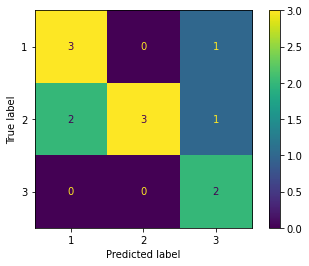

Accuracy 0.6666666666666666

              precision    recall  f1-score   support

           1       0.60      0.75      0.67         4
           2       1.00      0.50      0.67         6
           3       0.50      1.00      0.67         2

    accuracy                           0.67        12
   macro avg       0.70      0.75      0.67        12
weighted avg       0.78      0.67      0.67        12



In [19]:
lgr = fit_and_eval(
    LogisticRegression(n_jobs=10, C=1, class_weight="balanced"),
    X_train, x_val, Y_train, y_val
)

Results are similar to previous approach, however the model more often predicts label 3. This could be leveraged if we wanted to use a model ensemble.

### TF-IDF

Now we'll try to use word vectors retrieved by using TF-IDF and compare the results. We'll pass provided tumorboard keywords as vectorizer's vocabulary.

In [20]:
tfidf_vectorizer = TfidfVectorizer()
vectors = tfidf_vectorizer.fit([*train_df.clean_text, *test_df.clean_text])

Vectorizing with TF-IDF is much faster than computing average text vectors with spacy. Let's check how it works out.

In [21]:
x = np.stack(tfidf_vectorizer.transform(os_train_df.clean_text).todense().tolist())
y = os_train_df.label.to_numpy()

X_train, x_val, Y_train, y_val = train_test_split(x, y, train_size=0.9, shuffle=True, random_state=1, stratify=y)

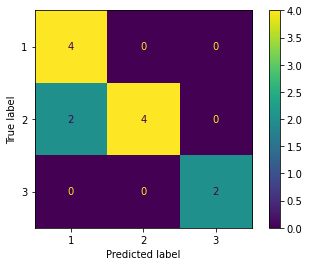

Accuracy 0.8333333333333334

              precision    recall  f1-score   support

           1       0.67      1.00      0.80         4
           2       1.00      0.67      0.80         6
           3       1.00      1.00      1.00         2

    accuracy                           0.83        12
   macro avg       0.89      0.89      0.87        12
weighted avg       0.89      0.83      0.83        12



In [22]:
lgr = fit_and_eval(
    LogisticRegression(n_jobs=10, C=1, class_weight="balanced"),
    X_train, x_val, Y_train, y_val
)

TF-IDF vectors gave us better results than spacy's word embeddings. Because of this and their faster generation time we'll stick to them. Maybe using larger language model could improve word embeddings performance, however due to reasons I mentioned before we won't be using them.

Let's try out some other models for this task. First - support vector machine model.

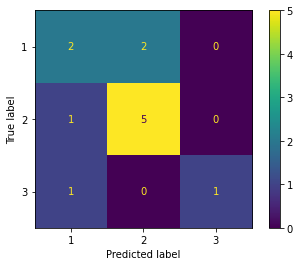

Accuracy 0.6666666666666666

              precision    recall  f1-score   support

           1       0.50      0.50      0.50         4
           2       0.71      0.83      0.77         6
           3       1.00      0.50      0.67         2

    accuracy                           0.67        12
   macro avg       0.74      0.61      0.65        12
weighted avg       0.69      0.67      0.66        12



In [23]:
svc = fit_and_eval(
    LinearSVC(penalty='l2', loss='hinge', dual=True, random_state=0, max_iter=100),
    X_train, x_val, Y_train, y_val
)

As we can see the results are worse than with LogisticRegression.

Now let's try out a Linear Support Vector Machine with l1 regularization.

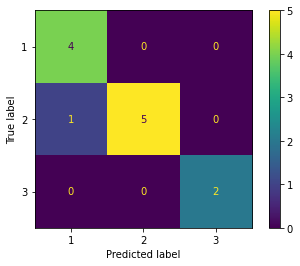

Accuracy 0.9166666666666666

              precision    recall  f1-score   support

           1       0.80      1.00      0.89         4
           2       1.00      0.83      0.91         6
           3       1.00      1.00      1.00         2

    accuracy                           0.92        12
   macro avg       0.93      0.94      0.93        12
weighted avg       0.93      0.92      0.92        12



In [24]:
sgd = fit_and_eval(
    SGDClassifier(penalty='l1', loss='hinge', alpha=1e-3, random_state=0, max_iter=100),
    X_train, x_val, Y_train, y_val
)

SGD gave us the best performance from all the ones tried, so we'll stick to this model.

### Binary approach

Another approach we can try is to convert labels to binary. As labels 2 and 3 mean similar things but with different level of certainity we can try to group them together. With this approach however we'd need a way to differentiate between those two classes afterwards. We could use prediction probability for this task.

In [25]:
Y_train_bin = np.array([2 if l == 3 else l for l in Y_train])
y_val_bin = np.array([2 if l == 3 else l for l in y_val])

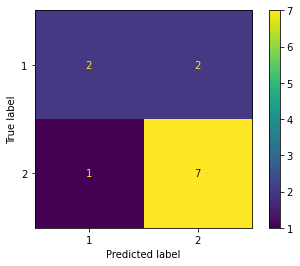

Accuracy 0.75

              precision    recall  f1-score   support

           1       0.67      0.50      0.57         4
           2       0.78      0.88      0.82         8

    accuracy                           0.75        12
   macro avg       0.72      0.69      0.70        12
weighted avg       0.74      0.75      0.74        12



In [26]:
sgd_bin = fit_and_eval(
    SGDClassifier(penalty='l1', loss='hinge', alpha=1e-3, random_state=0, max_iter=100),
    X_train, x_val, Y_train_bin, y_val_bin
)

As we can see results for binary classification in this case turn out to be worse than for multiclassification so we'll abandon this path.

### Final algorithm

We'll use the SGDClassifier with the same configuration as before and TF-IDF vectors as this was the combination that gave us the best results, but we'll use all training data this time.

No need to redefine training data, as TF-IDF vectors where the last ones generated. We'll just use `x` and `y` variables.

In [27]:
clf = SGDClassifier(penalty='l1', loss='hinge', alpha=1e-3, random_state=0, max_iter=100)
clf.fit(x, y)

SGDClassifier(alpha=0.001, max_iter=100, penalty='l1', random_state=0)

Now we'll transform test data texts to vectors with the previously trained TF-IDF vectorizer and predict classes

In [28]:
test_df['vectors'] = tfidf_vectorizer.transform(test_df['clean_text']).todense().tolist()
test_df['prediction'] = clf.predict(np.stack(test_df['vectors']))
    
test_df.prediction.value_counts()

2    39
1     7
3     2
Name: prediction, dtype: int64

Distribution of test predictions is very imbalanced which worries me a little. The group size order is similar to group sizes from the training data, however group 2 proportion to others is almost twice larger.

Finally let's save our results to file.

In [29]:
result_df = test_df[['doc_id', 'prediction']]
result_df.to_csv("submission.csv")

# Extra mile

We'll try to tackle this task by using LDA again, this time for topic modelling based only on keywords related to specific tumor types. Then we'll try to identify their schedule by detecting words corresponding to it.

First we'll make needed imports.

In [53]:
from collections import defaultdict, Counter
from functools import partial

Now let's load our keyword data and take a look at all the unique tumor types provided.

In [42]:
kw2tt = pd.read_csv("keyword2tumor_type.csv")
kw2tt_dict = dict(zip(kw2tt.keyword, kw2tt.tumor_type))
kw2tt.tumor_type.unique()

array(['Brust', 'Darm', 'Endokrine malignome',
       'Gallenblasen/gallengangkrebs', 'Gynäkologie', 'Harnblase', 'Haut',
       'Hoden, penis', 'Hämatooncology', 'Kopf-hals', 'Leber', 'Lunge',
       'Lymphom', 'Magen', 'Mamma carcinoma', 'Neuroonkologie', 'Niere',
       'Pankreas', 'Prostata', 'Rare cancer', 'Sarkome', 'Speiseröhre',
       'Urologische', 'Adenoid', 'Adrenal', 'Bauchspeicheldrüsenkrebs',
       'Interdisziplinär', 'Knochentumoren', 'Mikroskopieren',
       'Molekular', 'Oral', 'Prätherapeutische', 'Pädiatrische',
       'Schwerpunkt', 'Stammzelltransplantation', 'Surgical'],
      dtype=object)

There's quite a lot of them, which might make identifying 3 distinct groups challenging.

We'll assume that predictions from the previous step are somewhat correct and use them together with training data to model our topics. We'll also filter out texts from group 1, as they are supposed to not be mentioning tumorboards at all.

In [43]:
test_df.columns = [
    "label" if col == "prediction" else col
    for col in test_df.columns
]

full_df = pd.concat([
    train_df[['doc_id', 'label', 'clean_text']],
    test_df[['doc_id', 'label', 'clean_text']]
])
tb_df = full_df[full_df['label'].apply(lambda l: l in {2, 3})]
tb_df

,doc_id,label,clean_text
1,3,3,onkologisches zentrum klinikum bayreuth aktuel...
4,6,3,zuweiser tumorkonferenzen tumorkonferenz gastr...
10,13,2,krebszentrum reutlingen zentrale einrichtung k...
11,14,2,leistungsspektrum sankt marienhospital buer gm...
12,17,2,minimalinvasive chirurgie sankt marienhospital...
...,...,...,...
42,127,2,vendor neutral archiving solutions vna siemens...
43,134,2,zweitmeinung â einschãtzung sinnvoll universit...
44,135,2,ukb universitätsklinikum bonn medizinisch faku...
45,142,2,tumorboard lungenkrebszentrums mãglicherweise ...


### Tumor type classification

Now let's extract necessary keywords from our texts.

In [44]:
def get_keywords(text: str) -> list[str]:
    """
    Compares text words to our keyword set
    """
    global kw2tt
    
    keywords = (
        set(text.split())
        .intersection(set(kw2tt.keyword))
    )
    
    return list(keywords)

tb_df['keywords'] = tb_df['clean_text'].apply(get_keywords)
tb_df

,doc_id,label,clean_text,keywords
1,3,3,onkologisches zentrum klinikum bayreuth aktuel...,"[viszeralchirurgie, krebszentrum, gastroentero..."
4,6,3,zuweiser tumorkonferenzen tumorkonferenz gastr...,"[viszeralchirurgie, gastrointestinaltrakt, gas..."
10,13,2,krebszentrum reutlingen zentrale einrichtung k...,"[krebszentrums, brustzentrum, krebszentrum]"
11,14,2,leistungsspektrum sankt marienhospital buer gm...,"[allgemeine, viszeralchirurgie, radiologisch, ..."
12,17,2,minimalinvasive chirurgie sankt marienhospital...,"[allgemeine, viszeralchirurgie, radiologisch, ..."
...,...,...,...,...
42,127,2,vendor neutral archiving solutions vna siemens...,"[hämatologie, urologie, mammographie]"
43,134,2,zweitmeinung â einschãtzung sinnvoll universit...,"[allgemeine, urologische]"
44,135,2,ukb universitätsklinikum bonn medizinisch faku...,"[interdisziplinär, radiologisch, lungenkrebs, ..."
45,142,2,tumorboard lungenkrebszentrums mãglicherweise ...,[lungenkrebszentrum]


Next we'll perform LDA only on the keywords related to tumor types, as this approach will make topic interpretation easier.

In [51]:
dictionary = Dictionary(tb_df.keywords)
bow_corpus = [dictionary.doc2bow(doc) for doc in tb_df.keywords]

lda = LdaMulticore(bow_corpus, 
                   num_topics = 3,  # 3 topics, as we're looking for interdisciplinary, breast and one other only
                   id2word = dictionary,
                   passes = 10, 
                   workers = 2,
                   random_state=5)
lda.show_topics()

[(0,
  '0.100*"urologie" + 0.096*"gastroenterologie" + 0.075*"krebszentrum" + 0.066*"viszeralchirurgie" + 0.063*"brustzentrum" + 0.063*"darmkrebszentrum" + 0.061*"allgemeine" + 0.051*"urologische" + 0.050*"schwerpunkt" + 0.041*"magen"'),
 (1,
  '0.128*"thorax" + 0.064*"lungenkrebszentrum" + 0.064*"lungenkrebs" + 0.053*"darmkrebs" + 0.044*"sarkome" + 0.039*"chirurgisch" + 0.037*"schwerpunkt" + 0.036*"darmkrebszentrum" + 0.034*"endokrine" + 0.032*"krebszentrums"'),
 (2,
  '0.114*"schwerpunkt" + 0.092*"gastroenterologie" + 0.083*"brustzentrum" + 0.073*"viszeralchirurgie" + 0.067*"allgemeine" + 0.058*"radiologisch" + 0.053*"darmkrebs" + 0.043*"leber" + 0.041*"mammographie" + 0.040*"magen"')]

It's hard to draw conclusions from just the topics' keywords, so let's translate them to their corresponding tumor types.

In [52]:
def lda_topic_keywords2tumor_types(
    keywords: list[str]
) -> list[tuple[str, float]]:
    """
    Converts passed LDA topic keywords string and converts them
    to tumor types. Then returns a sorted list based on each 
    type's average probabilty.
    """
    topic_kws = [kw.split("*") for kw in keywords.split(" + ")]
    
    tumor_type_probs = defaultdict(list)
    for prob, kw in topic_kws:
        tumor_type = kw2tt_dict[kw[1:-1]]
        tumor_type_probs[tumor_type].append(float(prob))

    return sorted(
        [
            (tt, np.mean(probs))
            for tt, probs in tumor_type_probs.items()
        ], 
        key=lambda x: -x[1]
    )

for id_, kws in lda.show_topics():
    print(id_)
    pprint(lda_topic_keywords2tumor_types(kws))

0
[('Urologische', 0.0755),
 ('Magen', 0.0685),
 ('Interdisziplinär', 0.068),
 ('Darm', 0.0645),
 ('Brust', 0.063),
 ('Schwerpunkt', 0.05)]
1
[('Brust', 0.128),
 ('Lunge', 0.064),
 ('Darm', 0.0445),
 ('Sarkome', 0.044),
 ('Surgical', 0.039),
 ('Schwerpunkt', 0.037),
 ('Endokrine malignome', 0.034),
 ('Interdisziplinär', 0.032)]
2
[('Schwerpunkt', 0.114),
 ('Brust', 0.083),
 ('Magen', 0.066),
 ('Darm', 0.063),
 ('Interdisziplinär', 0.0625),
 ('Leber', 0.043),
 ('Mamma carcinoma', 0.041)]


This gives us some more insight inot what each topic is about. As we're supposed to identify interdisciplinar, breast and any third type of tumor board let's assume following groups:
- 0 - for this classification we'll assume it's about urological tumor boards, however due to small diferences between probability distributions it could also be some kind of gastrological tumor board or interdisciplinary.
- 1 - here we'll asume it's breast tumor board, as it is the top type of this group, with probability 2 times higher than the second one listed
- 2 - for last group we'll assume interdisciplinary tumor board, as the tumor types in this group are pretty varied.

Let's apply this classification to our data.

In [48]:
def doc2group(doc: str) -> int:
    """
    Converts text document to group 
    with previously trained LDA model.
    """
    global dictionary
    global lda
    
    if not doc:
        return None
    
    bow = dictionary.doc2bow(doc)
    groups = lda[bow]
    
    top_group, _ = max(groups, key=lambda x: x[1])
    
    return int(top_group)

tb_df['board_type'] = tb_df['keywords'].apply(doc2group)
tb_df['board_type'].value_counts()

2.0    52
0.0    43
1.0    12
Name: board_type, dtype: int64

As we can see the biggest group concerns interdisciplinary tumor boards, which seems probable, as interdisciplinary tumor boards probably concern a bigger group of tumors in general. However the second most numerous group is the one we assumed to be urological. The fact that it's count is only 9 smaller than the interdisciplinary group could mean for example that some interdisciplinary tumor boards got counted into this group. This would also explain the small variation between the tumor types in this group in the previous step.

### Schedule identification

The most reliable method for this task would be to use Named Entity Recognition system, trained to detect entities about time, dates, frequencies etc. Spacy has an inbuilt NER functionality which could be taken advantage of for this task, however unfortunately none of the german language models have predefined entities regarding the information we're trying to find. We could train given models with our own data, however this would require additional time for data gathering and tagging of the entities.

Because of this I decided only to try a simple approach of finding weekdays or words about time frequency in our pages.

In [54]:
def find_most_frequent(words: str, text: str) -> str:
    """
    Finds all the occurances of words from passed wordlist
    in the passed text and returns the word with the most
    frequent occurance.
    """
    tokens = text.split()
    found_words = set(tokens).intersection(words)
    word_counts = Counter(tokens)
    
    found_words_counts = defaultdict(int)
    for wd in found_words:
        found_words_counts[wd] += word_counts[wd]
    
    if not found_words_counts:
        return None
    
    most_freq_word, _ = max(
        found_words_counts.items(), 
        key=lambda x: x[1]
    )
    
    return most_freq_word

weekdays = {
    'sonntag', 
    'montag', 
    'dienstag', 
    'mittwoch', 
    'donnerstag', 
    'freitag', 
    'samstag'
}
find_weekday = partial(find_most_frequent, weekdays)

tb_df['weekday'] = tb_df['clean_text'].apply(find_weekday)
tb_df[~tb_df.weekday.isna()].shape[0] / tb_df.shape[0]

0.25688073394495414

In [55]:
frequency_words = {
    'woche',
    'monat'
}
find_frequency = partial(find_most_frequent, frequency_words)

tb_df['period'] = tb_df['clean_text'].apply(find_frequency)
tb_df[~tb_df.period.isna()].shape[0] / tb_df.shape[0]

0.21100917431192662